## Load the necessary packages and files

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import gc
import os
import PIL
from pathlib import Path
from IPython.display import clear_output
import cv2

from scipy import stats
from multiprocessing import Pool
from PIL import ImageOps, ImageFilter
from tqdm import tqdm
from wordcloud import WordCloud

tqdm.pandas()

In [2]:
df_train = pd.read_csv('../input/train-file-with-labels-and-meta-data/weird_images_w_labels.csv')
train_path = '../input/imet-2019-fgvc6/train/'
label_df = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')

print('Files loaded!')

Files loaded!


In [3]:
labels_df = pd.read_csv("../input/imet-2019-fgvc6/labels.csv")

In [4]:
labels_df.head()

,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


In [5]:
labels_df.tail()

,attribute_id,attribute_name
1098,1098,tag::writing implements
1099,1099,tag::writing systems
1100,1100,tag::zeus
1101,1101,tag::zigzag pattern
1102,1102,tag::zodiac


In [6]:
train_df = pd.read_csv("../input/imet-2019-fgvc6/train.csv")
train_df.head()

,id,attribute_ids
0,1000483014d91860,147 616 813
1,1000fe2e667721fe,51 616 734 813
2,1001614cb89646ee,776
3,10041eb49b297c08,51 671 698 813 1092
4,100501c227f8beea,13 404 492 903 1093


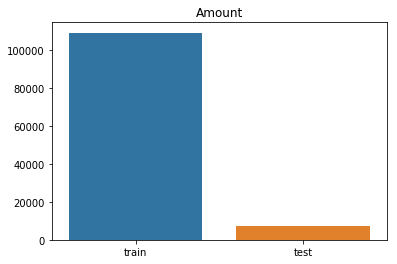

In [7]:
test_path = Path("../input/imet-2019-fgvc6/test/")
test_num = len(list(test_path.glob("*.png")))
train_num = len(train_df)
fig, ax = plt.subplots()
sns.barplot(x=["train", "test"], y=[train_num, test_num])
ax.set_title("Amount")
clear_output()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


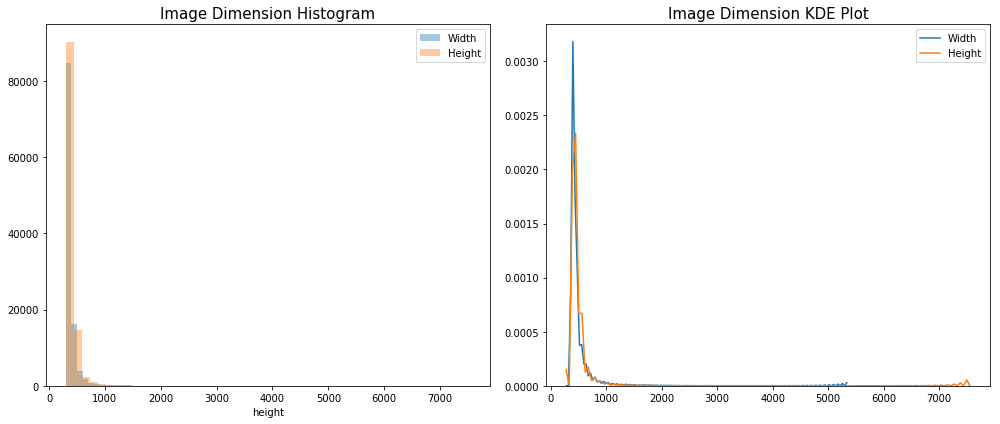

In [8]:
plt.figure(figsize=(14,6))
plt.subplot(121)
sns.distplot(df_train['width'],kde=False, label='Width')
sns.distplot(df_train['height'], kde=False, label='Height')
plt.legend()
plt.title('Image Dimension Histogram', fontsize=15)

plt.subplot(122)
sns.kdeplot(df_train['width'], label='Width')
sns.kdeplot(df_train['height'], label='Height')
plt.legend()
plt.title('Image Dimension KDE Plot', fontsize=15)

plt.tight_layout()
plt.show()

### Turns out they are only huge in either width or height

Something pretty long?

In [9]:
df_train[['width','height']].sort_values(by='width',ascending=False).head()

,width,height
47121,5314.0,300.0
47102,4938.0,300.0
73509,4428.0,300.0
50559,4080.0,300.0
62117,3998.0,300.0


In [10]:
df_train[['width','height']].sort_values(by='height',ascending=False).head()

,width,height
56558,300.0,7531.0
46045,300.0,5687.0
43370,300.0,3150.0
83833,300.0,3015.0
101395,300.0,3012.0


### Weird images with Huge Height and Width

In [11]:
weird_height_id = [v for v in df_train.sort_values(by='height',ascending=False).head(20)['id'].values]
weird_width_id = [v for v in df_train.sort_values(by='width',ascending=False).head(20)['id'].values]

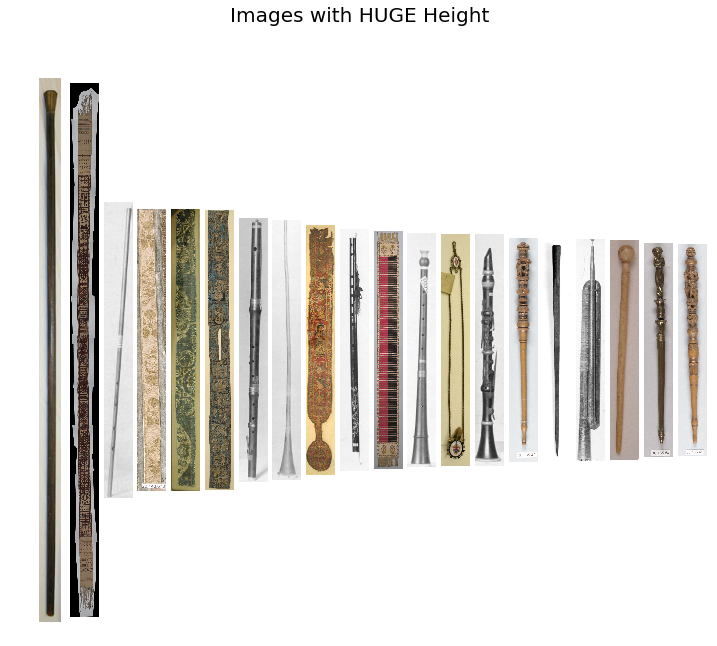

In [12]:
plt.figure(figsize=(12,10))

for num, img_id in enumerate(weird_height_id):
    img = PIL.Image.open(f'{train_path}{img_id}.png')
    plt.subplot(1,20,num + 1)
    plt.imshow(img)
    plt.axis('off')
    
plt.suptitle('Images with HUGE Height', fontsize=20)
plt.show()

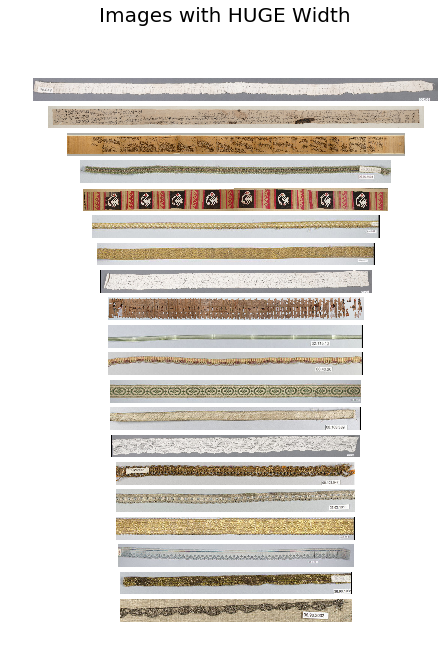

In [13]:
plt.figure(figsize=(12,10))

for num, img_id in enumerate(weird_width_id):
    img = PIL.Image.open(f'{train_path}{img_id}.png')
    plt.subplot(20,1,num + 1)
    plt.imshow(img)
    plt.axis('off')
    
plt.suptitle('Images with HUGE Width', fontsize=20)
plt.show()

### Turns out they are all long artifacts/ accessories

During the pre-processing steps, these images should be padded instead of being resized to a square. 

Or perhaps a custom pre-processing steps can be applied to images of vastly different size like the weird images above? I will leave that to you to explore.

In [14]:
img = PIL.Image.open(f'{train_path}{weird_height_id[0]}.png')

w_resized = int(img.size[0] * 300 / img.size[1])
resized = img.resize((w_resized ,300))
pad_width = 300 - w_resized
padding = (pad_width // 2, 0, pad_width-(pad_width//2), 0)
resized_w_pad = ImageOps.expand(resized, padding)

resized_wo_pad = img.resize(size=(300,300))

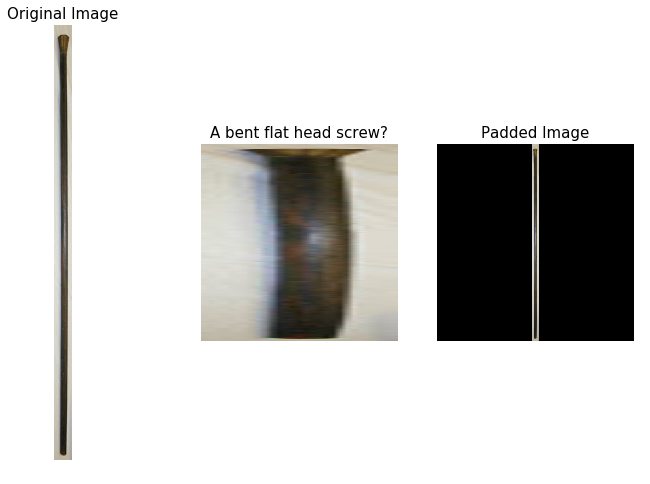

In [15]:
plt.figure(figsize=(12,8))

plt.subplot(131)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image',fontsize=15)

plt.subplot(132)
plt.imshow(resized_wo_pad)
plt.axis('off')
plt.title('A bent flat head screw?',fontsize=15)

plt.subplot(133)
plt.imshow(resized_w_pad)
plt.axis('off')
plt.title('Padded Image',fontsize=15)

plt.show()

# Find Number of Labels Seperate by Culture and Tag

In [16]:
label_names = label_df['attribute_name'].values

num_labels = np.zeros((df_train.shape[0],))
train_labels = np.zeros((df_train.shape[0], len(label_names)))

for row_index, row in enumerate(df_train['attribute_ids']):
    num_labels[row_index] = len(row.split())    
    for label in row.split():
        train_labels[row_index, int(label)] = 1

In [17]:
culture, tag, unknown = 0, 0, 0

for l in label_names:
    if l[:3] == 'cul':
        culture += 1
    elif l[:3] == 'tag':
        tag += 1
    else:
        unknown += 1
        
print(f'Culture : {culture}')
print(f'Tag     : {tag}')
print(f'Unknown : {unknown}')
print(f'Total   : {culture + tag + unknown}')

Culture : 398
Tag     : 705
Unknown : 0
Total   : 1103


### Find Number of Labels per Image

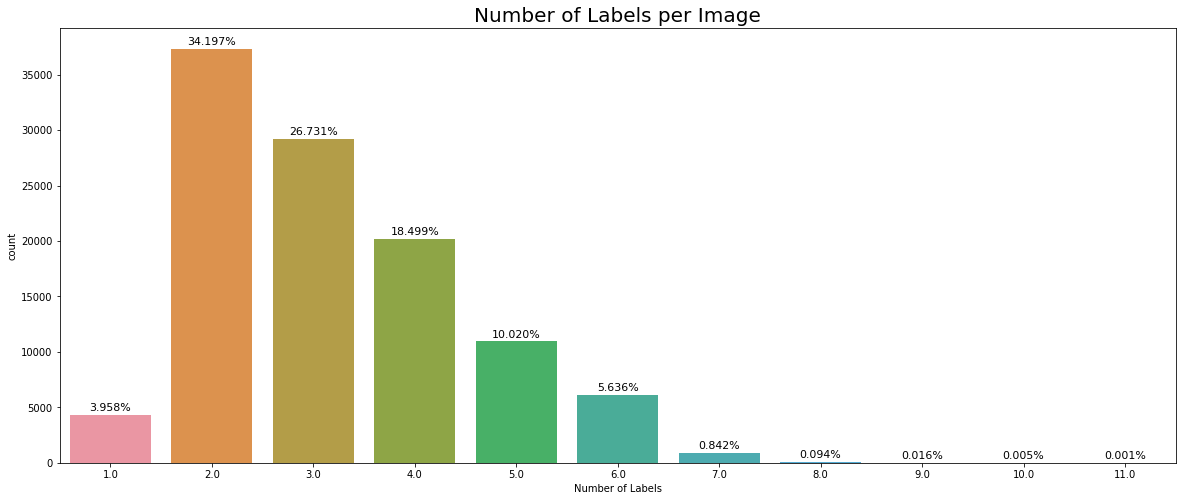

In [18]:
plt.figure(figsize=(20,8))

ax = sns.countplot(num_labels)
plt.xlabel('Number of Labels')
plt.title('Number of Labels per Image', fontsize=20)

for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100 / df_train.shape[0]:.3f}%',
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            fontsize=11, 
            color='black',
            xytext=(0,7), 
            textcoords='offset points')

### Try to remove Image Background

In [19]:
def rem_bkg(img):
    y_size,x_size,col = img.shape
    
    for y in range(y_size):
        for r in range(1,6):
            col = img[y, x_size-r] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]
        for l in range(5):
            col = img[y, l] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]

    for x in range(x_size):
        for d in range(1,6):
            col = img[y_size-d, x] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]
        for u in range(5):
            col = img[u, x] 
            img[np.where((img == col).all(axis = 2))] = [255,255,255]
    
    return img

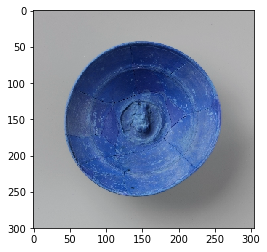

In [23]:
img = cv2.imread("../input/imet-2019-fgvc6/train/100b45b7c4020f5d.png")
plt.imshow(img)

plt.show()  

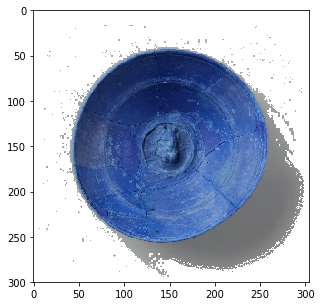

In [22]:
i = 1
plt.figure(figsize=[5,5])

img = cv2.imread("../input/imet-2019-fgvc6/train/100b45b7c4020f5d.png")

rem_bkg(img)    

plt.imshow(img)

plt.show()  